# Authors:

Daniel Vila de la Cruz

Sara Gómez Feás

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping


In [2]:
# Dataset path
from os import listdir
import os.path

PATH = r'C:\Users\dani_\OneDrive\Escritorio\MIA\Q2\DL\datasets\faces_dataset_train\faces_dataset_train/'
PATH_TEST = r'C:\Users\dani_\OneDrive\Escritorio\MIA\Q2\DL\datasets\faces_dataset_test\faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

In [3]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


In [4]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Image shape:  (32, 32, 3)
Label:  40


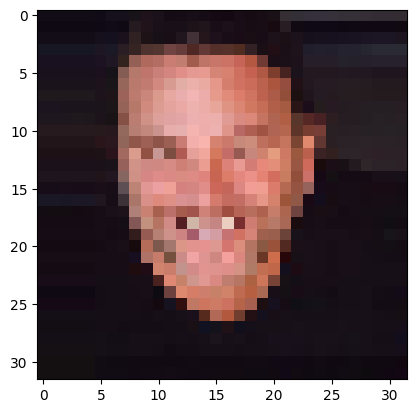

Image shape:  (32, 32, 3)
Label:  13


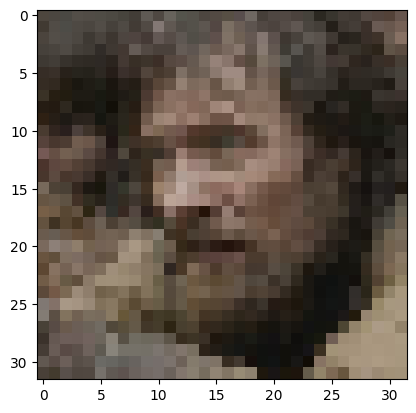

Image shape:  (32, 32, 3)
Label:  36


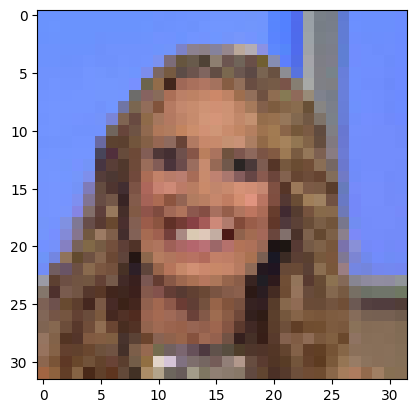

Image shape:  (32, 32, 3)
Label:  49


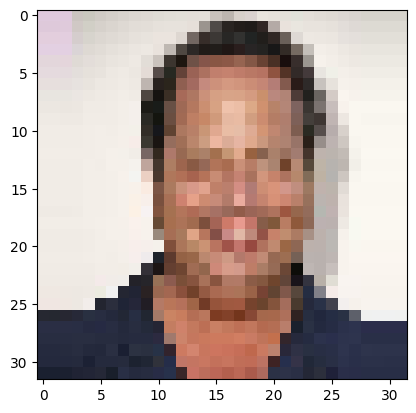

Image shape:  (32, 32, 3)
Label:  51


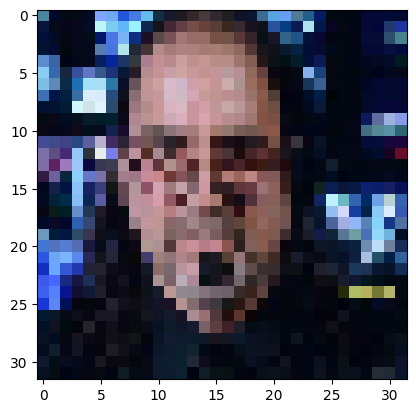

In [5]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    age = parts[1]
    age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
    gender = parts[2]
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, age


def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [6]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

C:\Users\dani_\OneDrive\Escritorio\MIA\Q2\DL\datasets\faces_dataset_train\faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


In [7]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
# OPTIONAL: rescaled output to [0, 1]
import numpy as np
labels = [int(x.split('|')[1]) for x in train_metadata]
max_age = tf.convert_to_tensor(np.max(labels), tf.float32)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))

In [9]:
# OPTIONAL: sample age weights
import numpy as np
step = 10
labels = [int(x.split('|')[1]) for x in train_metadata]
freqs, bins = np.histogram(labels, bins=list(range(0,100,step)) + [200])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))

tf.Tensor(
[1.76150383 0.08628557 0.01546083 0.01225852 0.01755069 0.03502511
 0.06879879 0.16056922 0.52553153 7.31701591], shape=(10,), dtype=float64)


In [10]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

# Fine-tunning approach

We are now going to use the model that we previously trained for gender prediction to predict age of individuals. For doing so, we load the pre-trained model and delete the last layer.

In [11]:
gender_model = load_model("model_dropout4.h5")
base_model = keras.models.Sequential(gender_model.layers[:-1])

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 30, 30, 32)        896       
                                                                 
 Conv2 (Conv2D)              (None, 28, 28, 32)        9248      
                                                                 
 Conv3 (Conv2D)              (None, 26, 26, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 Conv4 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 Conv5 (Conv2D)              (None, 9, 9, 64)          3

First, we freeze the base model in order to stop training it. Then we create the new model and link it to the base model. This new model consists on a fully connected layer with 128 neurons with a ReLU activation function and an output layer with a single neuron and a linear activation function. We also included a dropout with rate of 0.3 between the dense layers, in order to prevent overfitting, as well as using the early stopping parametter and a learning rate of 0.0005 with RMSprop optimizer.

In [12]:
base_model.trainable = False

inputs = keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
output = keras.layers.Dense(1, activation='linear')(x)
new_model = keras.Model(inputs, output)

new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 128)               165696    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 182,337
Trainable params: 16,641
Non-trainable params: 165,696
_________________________________________________________________


In [13]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

new_model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.0005), loss="mean_squared_error", metrics=["mean_absolute_error"], weighted_metrics=[])
history = new_model.fit(ds_train_batch, epochs=10, validation_data=(ds_test_batch), callbacks=[early_stopping])

Epoch 1/10
992/992 [==============================] - 228s 227ms/step - loss: 0.0649 - mean_absolute_error: 0.1380 - val_loss: 0.1496 - val_mean_absolute_error: 0.2445
Epoch 2/10
992/992 [==============================] - 174s 175ms/step - loss: 0.0331 - mean_absolute_error: 0.1072 - val_loss: 0.1330 - val_mean_absolute_error: 0.2314
Epoch 3/10
992/992 [==============================] - 121s 122ms/step - loss: 0.0321 - mean_absolute_error: 0.1055 - val_loss: 0.1563 - val_mean_absolute_error: 0.2479
Epoch 4/10
992/992 [==============================] - 119s 120ms/step - loss: 0.0317 - mean_absolute_error: 0.1050 - val_loss: 0.1427 - val_mean_absolute_error: 0.2383
Epoch 5/10
992/992 [==============================] - 120s 121ms/step - loss: 0.0315 - mean_absolute_error: 0.1048 - val_loss: 0.1323 - val_mean_absolute_error: 0.2300
Epoch 6/10
992/992 [==============================] - 120s 121ms/step - loss: 0.0314 - mean_absolute_error: 0.1045 - val_loss: 0.1469 - val_mean_absolute_error:

In [14]:
new_model.save("before_fine_dropout4.h5")

We unfreeze some of the layers of the base model and fine-tune the model, training it with a low learning rate (1e-5) in order to avoid making huge modifications that could nullify the features. We also added an Ealy Stopping parametter to avoid overfitting.

In [16]:
base_model.trainable = True
for layer in base_model.layers[:-3]:
    layer.trainable = False
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32)                152928    
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 157,281
Trainable params: 8,545
Non-trainable params: 148,736
_________________________________________________________________


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

new_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), loss="mean_squared_error", metrics=["mean_absolute_error"], weighted_metrics=[])

### history2
history2 = new_model.fit(ds_train_batch, epochs=10, validation_data=(ds_test_batch), callbacks=[early_stopping])

Epoch 1/10
992/992 [==============================] - 109s 109ms/step - loss: 0.0318 - mean_absolute_error: 0.1053 - val_loss: 0.1428 - val_mean_absolute_error: 0.2390
Epoch 2/10
992/992 [==============================] - 108s 108ms/step - loss: 0.0317 - mean_absolute_error: 0.1049 - val_loss: 0.1423 - val_mean_absolute_error: 0.2386
Epoch 3/10
992/992 [==============================] - 111s 112ms/step - loss: 0.0316 - mean_absolute_error: 0.1049 - val_loss: 0.1428 - val_mean_absolute_error: 0.2390
Epoch 4/10
992/992 [==============================] - 116s 117ms/step - loss: 0.0316 - mean_absolute_error: 0.1049 - val_loss: 0.1427 - val_mean_absolute_error: 0.2389
Epoch 5/10
992/992 [==============================] - 127s 128ms/step - loss: 0.0315 - mean_absolute_error: 0.1048 - val_loss: 0.1422 - val_mean_absolute_error: 0.2384
Epoch 6/10
992/992 [==============================] - 138s 139ms/step - loss: 0.0315 - mean_absolute_error: 0.1047 - val_loss: 0.1422 - val_mean_absolute_error:

In [18]:
new_model.save("after_fine_dropout2.h5")

In [21]:
loss,mae=new_model.evaluate(ds_test_batch)

8/8 [==============================] - 7s 115ms/step - loss: 0.1431 - mean_absolute_error: 0.2393


In [22]:
# Check how many years does the error account for
max_age=99
print("Predictions are off by an average of", mae*max_age, "years") 

Predictions are off by an average of 23.69144180417061 years


## Before fine-tunning plots

<Figure size 640x480 with 0 Axes>

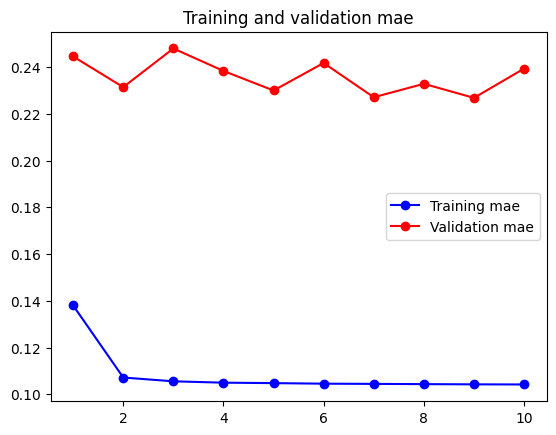

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

mae = history.history["mean_absolute_error"]
val_mae = history.history["val_mean_absolute_error"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, "b-o", label="Training mae")
plt.plot(epochs, val_mae, "r-o", label="Validation mae")
plt.title("Training and validation mae")
plt.legend()
plt.figure()

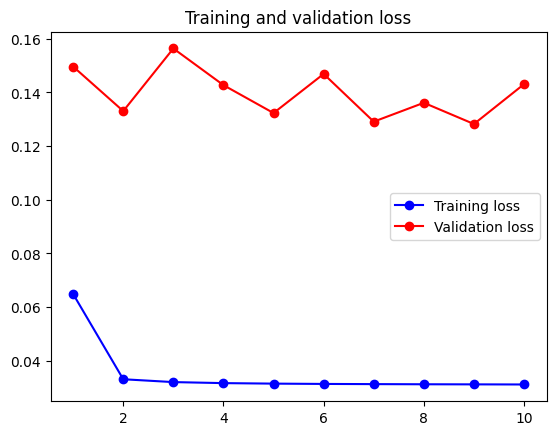

In [16]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## After fine-tunning plots

<Figure size 640x480 with 0 Axes>

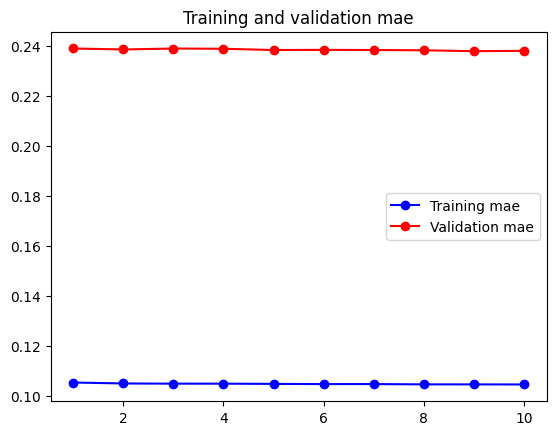

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

mae = history2.history["mean_absolute_error"]
val_mae = history2.history["val_mean_absolute_error"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, "b-o", label="Training mae")
plt.plot(epochs, val_mae, "r-o", label="Validation mae")
plt.title("Training and validation mae")
plt.legend()
plt.figure()

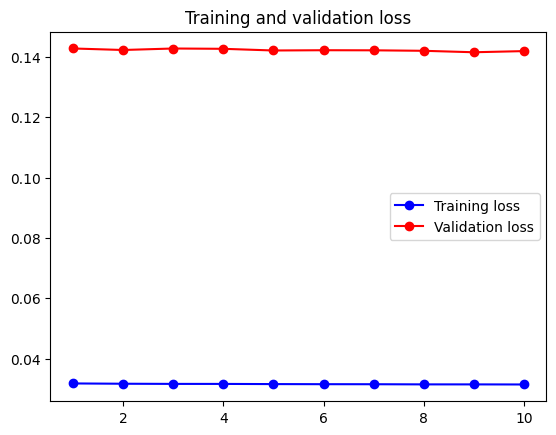

In [22]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Conclusions

As we can see on the plots previous to fine tune, there is a bit of overfitting before fine-tunning the model, as we are using a pre-trained model to extract the features, but the on the plots after fine-tunning we can see that both training and validation remain almost the same during all epochs. This occurs due to the low learning rate used when fine-tunning.

We achieve a MAE of 0.2393 and a loss of 0.1431, which we consider pretty decent, taking into account the pixelated images of only 32x32 pixels. Again, maybe an increase in the definition of the images may lead to better results, but at the cost of way higher time consumption to train the models.

Comparing it with the Feature Extraction model, the fine-tunning approach achieves a slightly better results. Using the first one, predictions are off by an average of 23.816818848252296 years, while with the second one 23.69144180417061 years. Again, those results are not entirely reliables, as we don't have a proper test set that doesn't have data used for training or validation, so we can not be secure on how well the models will perform on unseen data.

Aside from that, we consider that both models performed pretty decent, which proves that transfer learning is duable for this scenario. We accuse the results of not being better due to the resolution of the images. The biggest advantage of transfer learning is that using a pre-trained model saves a lot of time, but in this case, as the base model was not that complex, this was not an advantage at all. For bigger models, or models that require data augmentation or some methods that slows down their training, it is a very useful technique. Also add, that since fine-tuning requires training the model twice, it is much slower than feature extraction.